In [39]:
import numpy as np
import xgboost as xgb
import matplotlib.pylab as plt
from sklearn.cross_validation import train_test_split

%matplotlib inline

## Construct a simulated data set for testing monotonic constraintsx

In [40]:
N, K = (1000, 2)
pi = 3.14159

In [41]:
X = np.random.random(size=(N, K))
y = (5*X[:, 0] + np.sin(5*2*pi*X[:, 0])
     - 5*X[:, 1] - np.cos(5*2*pi*X[:, 1])
     #+ 0.01*np.sin(5*2*pi*X[:, 0])*np.cos(5*2*pi*X[:, 1])
     + np.random.normal(loc=0.0, scale=0.01, size=N))

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

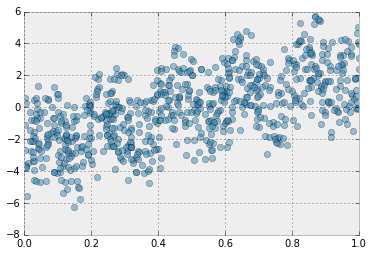

In [65]:
plt.plot(X_train[:, 0], y_train, 'o', alpha = 0.5)

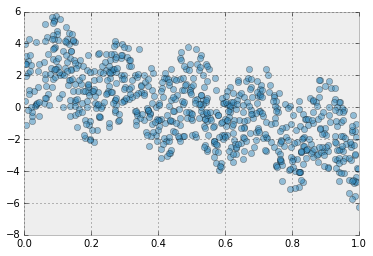

In [52]:
plt.plot(X_train[:, 1], y_train, 'o', alpha = 0.5)

## Fit a xgboost model - Unconstrained

In [56]:
params = {
    'max_depth': 2,
    'eta': 0.1,
    'silent': 0,
    'eval_metric': 'rmse',
    'seed': 154
}

Train a xgboost model on only the first feature, the ground truth is a sin wave superimposed on an increasing trend.

In [57]:
dtrain = xgb.DMatrix(X_train[:, [0]], label = y_train)
dvalid = xgb.DMatrix(X_test[:, [0]], label = y_test)

evallist  = [(dtrain, 'train'), (dvalid, 'eval')]
model_no_constraints = xgb.train(params, dtrain, 
                                 num_boost_round = 1000, evals = evallist, 
                                 early_stopping_rounds = 10)

[0]	train-rmse:2.19211	eval-rmse:2.0942
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[1]	train-rmse:2.10645	eval-rmse:2.02706
[2]	train-rmse:2.03432	eval-rmse:1.97244
[3]	train-rmse:1.97336	eval-rmse:1.92631
[4]	train-rmse:1.92227	eval-rmse:1.88864
[5]	train-rmse:1.87938	eval-rmse:1.85904
[6]	train-rmse:1.84376	eval-rmse:1.83541
[7]	train-rmse:1.81398	eval-rmse:1.81578
[8]	train-rmse:1.7892	eval-rmse:1.79937
[9]	train-rmse:1.7688	eval-rmse:1.78794
[10]	train-rmse:1.7516	eval-rmse:1.777
[11]	train-rmse:1.7364	eval-rmse:1.76859
[12]	train-rmse:1.72405	eval-rmse:1.76163
[13]	train-rmse:1.71258	eval-rmse:1.75585
[14]	train-rmse:1.70261	eval-rmse:1.7513
[15]	train-rmse:1.69402	eval-rmse:1.74787
[16]	train-rmse:1.68664	eval-rmse:1.7452
[17]	train-rmse:1.67971	eval-rmse:1.7412
[18]	train-rmse:1.67381	eval-rmse:1.73986
[19]	train-rmse:1.6659	eval-rmse:1.73562
[20]	train-rmse:1.66077	eval-rmse:1.73

In [66]:
def plot_one_feature_prediction(bst, X, y, title):
    """For one-feature model, plot data and prediction."""
    
    x_scan = np.linspace(0, 1, 100)
    x_plot = xgb.DMatrix(x_scan.reshape((len(x_scan),1)))
    y_plot = bst.predict(x_plot, ntree_limit = bst.best_ntree_limit)

    plt.plot(x_scan, y_plot, color = 'black')
    plt.plot(X, y, 'o', alpha = 0.25)

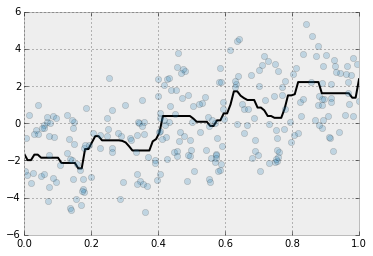

In [69]:
plot_one_feature_prediction(model_no_constraints, X_test[:, 0], y_test, "")

Add a monotonic constraint - constrain feature to be fit monotonically.

In [70]:
params_constrained = params.copy()
params_constrained['updater'] = "grow_monotone_colmaker,prune"
params_constrained['monotone_constraints'] = "(1)"

evallist  = [(dtrain, 'train'), (dvalid, 'eval')]
model_with_constraints = xgb.train(params_constrained, dtrain, 
                                 num_boost_round = 1000, evals = evallist, 
                                 early_stopping_rounds = 10)

[0]	train-rmse:2.19211	eval-rmse:2.0942
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[1]	train-rmse:2.10645	eval-rmse:2.02706
[2]	train-rmse:2.03432	eval-rmse:1.97244
[3]	train-rmse:1.97336	eval-rmse:1.92631
[4]	train-rmse:1.92227	eval-rmse:1.88864
[5]	train-rmse:1.87938	eval-rmse:1.85904
[6]	train-rmse:1.84376	eval-rmse:1.83541
[7]	train-rmse:1.81398	eval-rmse:1.81578
[8]	train-rmse:1.7892	eval-rmse:1.79937
[9]	train-rmse:1.7688	eval-rmse:1.78794
[10]	train-rmse:1.75165	eval-rmse:1.77728
[11]	train-rmse:1.73755	eval-rmse:1.77016
[12]	train-rmse:1.72565	eval-rmse:1.7641
[13]	train-rmse:1.71581	eval-rmse:1.75918
[14]	train-rmse:1.70772	eval-rmse:1.75653
[15]	train-rmse:1.70096	eval-rmse:1.75379
[16]	train-rmse:1.69539	eval-rmse:1.75264
[17]	train-rmse:1.69061	eval-rmse:1.75149
[18]	train-rmse:1.68671	eval-rmse:1.75082
[19]	train-rmse:1.68348	eval-rmse:1.75049
[20]	train-rmse:1.68083	eval-rm

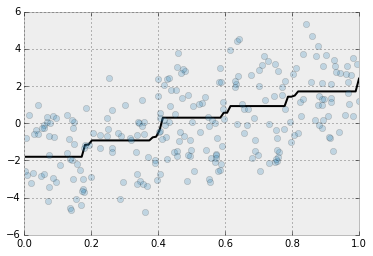

In [72]:
plot_one_feature_prediction(model_with_constraints, X_test[:, 0], y_test, "")